# Final Project: Load balancing
## Part 3 : Model-free control with Value Function/Policy approximation

#### Policy Approximation: softmax parametrization

Author : Jed MOUTAHIR

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
class LoadBalencingEnv(object): 
    # Class that defines the environment with reward 0 and 1 with probability p.

    def __init__(self, lambdA, mu1, mu2, gamma, Q1_max, Q2_max):
        self.lambdA = lambdA
        self.mu1 = mu1
        self.mu2 = mu2
        self.gamma = gamma
        self.Q1 = 0
        self.Q2 = 0
        self.state = (self.Q1, self.Q2)

        self.actions = np.arange(2)     # define set of actions
        self.Q1_max = Q1_max
        self.Q2_max = Q2_max

    def reward(self):
        return - (self.state[0] + self.state[1])
    
    def step(self, action):
        # Take action (0 or 1) and return reward.
        event = np.random.uniform()

        # Is there a departure?
        if(event < self.mu1 and self.Q1 > 0):
            self.Q1 -= 1
        elif(event < self.mu1 + self.mu2 and self.Q2 > 0):
            self.Q2 -= 1

        # Is there an arrival?
        elif(self.Q1 < self.Q1_max and self.Q2 < self.Q2_max and event < self.mu1 + self.mu2 + self.lambdA):
            # Choose queue
            if(self.Q1 == self.Q1_max):
                self.Q2 += 1
            elif(self.Q2 == self.Q2_max):
                self.Q1 += 1
            elif(action == 0):
                self.Q1 += 1
            elif(action == 1):
                self.Q2 += 1
        else:
            if((self.Q1 > self.Q1_max or self.Q2 > self.Q2_max) and (event < self.mu1 + self.mu2 + self.lambdA)):
                print("Error: impossible state : ")
                print("Q1 = ", self.Q1)
                print("Q2 = ", self.Q2)
                print("event = ", event)
                print("action = ", action)
                print("lambdA = ", self.lambdA)
                print("mu1 = ", self.mu1)
                print("mu2 = ", self.mu2)

        self.state = (self.Q1, self.Q2)
        reward = self.reward()

        return reward, self.state

In [4]:
def softmax_policy(theta1, theta2, state, action):
    if(action == 0):
        return np.exp(theta1*state[1])/(np.exp(theta1*state[1]) + np.exp(theta2*state[0]))
    elif(action == 1):
        return np.exp(theta2*state[0])/(np.exp(theta1*state[1]) + np.exp(theta2*state[0]))
    else:
        print("Error: action must be 0 or 1")
        return None

In [23]:
def softmax_approximation(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, num_episodes, learning_rate=0.0001, eps=1e-5):
    """ Function approxiamted the optimal policy using softmax approximation. """

    # Initialize environment
    env = LoadBalencingEnv(lambdA, mu1, mu2, gamma, Q1_max, Q2_max)

    # Initialize theta
    theta = (0, 0)
    prev_theta = theta

    for episode in range(num_episodes):
        # Initialize state
        state = (np.random.randint(env.Q1_max + 1), np.random.randint(env.Q2_max + 1))
        env.state = state
        env.Q1 = state[0]
        env.Q2 = state[1]

        # Get action probabilities
        action_probs = np.array([softmax_policy(theta[0], theta[1], state, a) for a in env.actions])

        # Choose action
        action = np.random.choice(env.actions, p=action_probs)

        # Take action
        reward, next_state = env.step(action)

        # Update theta
        theta = (theta[0] + learning_rate*(reward - theta[0]*state[1])*action_probs[0],
                 theta[1] + learning_rate*(reward - theta[1]*state[0])*action_probs[1])
        
        # Check convergence
        if(np.linalg.norm(np.array(theta) - np.array(prev_theta)) < eps):
            break

        prev_theta = theta

    # Compute optimal policy
    pi = np.zeros((env.Q1_max + 1, env.Q2_max + 1))
    for Q1 in range(env.Q1_max + 1):
        for Q2 in range(env.Q2_max + 1):
            pi[Q1, Q2] = np.argmax([softmax_policy(theta[0], theta[1], (Q1, Q2), a) for a in env.actions])

    return theta, pi

In [24]:
# Parameters
lambdA = 0.3
mu1 = 0.2
mu2 = 0.4
gamma = 0.99
Q1_max = 20
Q2_max = 20

In [25]:
# Compute optimal policy and value function
N = 100000
theta, policy = softmax_approximation(gamma, mu1, mu2, lambdA, Q1_max, Q2_max, N)

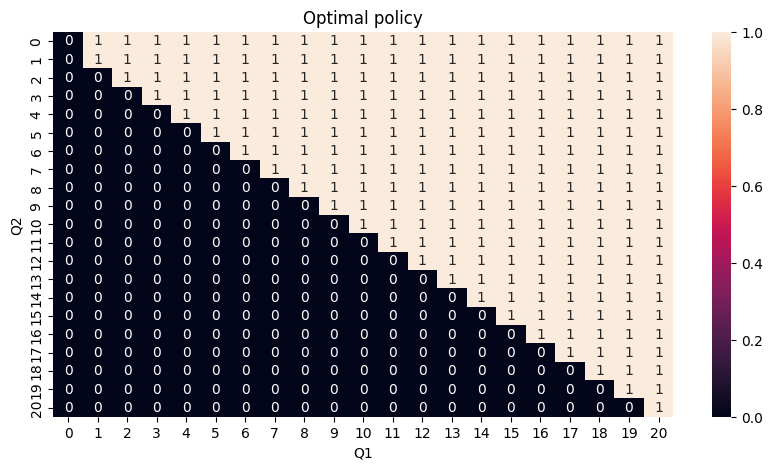

In [27]:
# Plot the optimal policy usins sns
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(policy, annot=True, ax=ax)
ax.set_title("Optimal policy")
ax.set_xlabel("Q1")
ax.set_ylabel("Q2")
plt.savefig("softmax_policy.png")
plt.show()
